In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
from Preprocessor import Preprocessor
from Registerer import Registerer
import SimpleITK as sitk
import ndreg
import numpy as np

### Step 1: Load data

In [4]:
img = ndreg.imgRead('../forVikram/ailey-dev_thy1eyfp_control_9_upload20170919_ch1_res3.img')
atlas = ndreg.imgRead('../forVikram/average_template_50.tif')

In [5]:
img.SetSpacing((0.04128, 0.04128, 0.04128))

In [6]:
atlas.SetSpacing((0.05, 0.05, 0.05))

### Step 2: initialize Preprocessor class

In [7]:
preprocessor = Preprocessor(img)

### Step 3: remove streaks

In [8]:
new_img = preprocessor.remove_streaks()

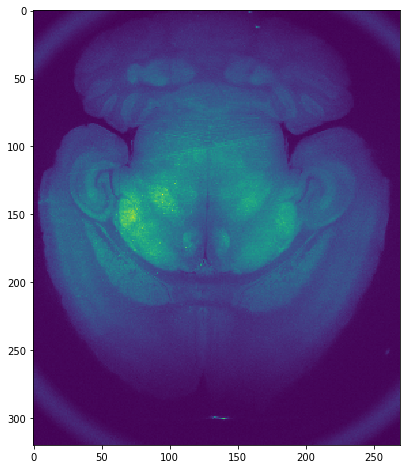

In [9]:
plt.imshow(preprocessor.img_np[80,:,:])
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


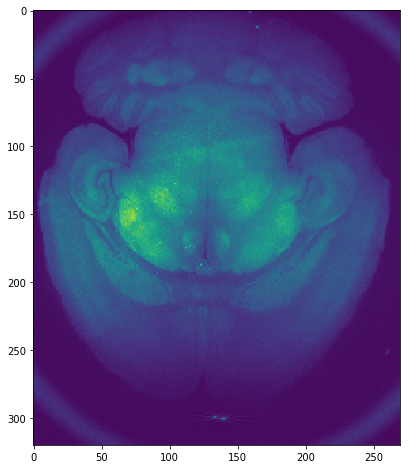

In [10]:
plt.imshow(new_img[80,:,:].astype('float'))
plt.show()

### Step 4: Remove circle

In [11]:
img_no_circle = preprocessor.remove_circle()

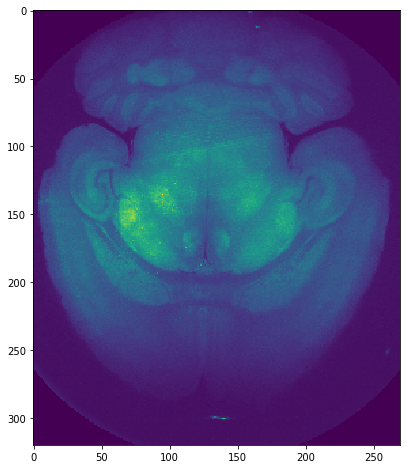

In [12]:
plt.imshow(img_no_circle[80,:,:])
plt.show()

### Step 5: create mask

In [13]:
mask = preprocessor.create_mask()

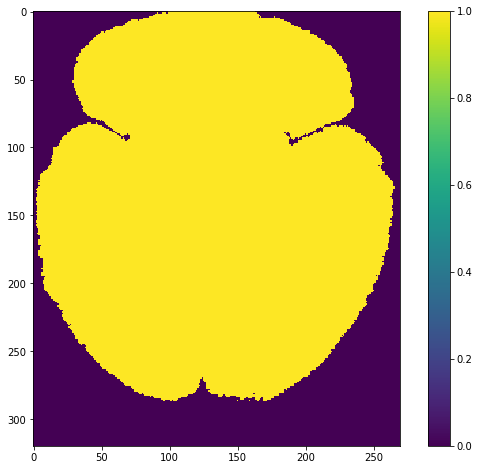

In [14]:
plt.imshow(mask[80,:,:])
plt.colorbar()
plt.show()

### Step 6: Correct Bias field

In [8]:
img_bias_corrected = preprocessor.correct_bias_field(scale=0.25)

NameError: name 'mask' is not defined

In [ ]:
ndreg.imgShow(img_bias_corrected, vmax=1000)

### Do it all at once

In [9]:
img_p = preprocessor.auto_preprocess()

In [10]:
img_p.GetSize()

(270, 320, 178)

In [11]:
img_p.GetSpacing()

(0.04128, 0.04128, 0.04128)

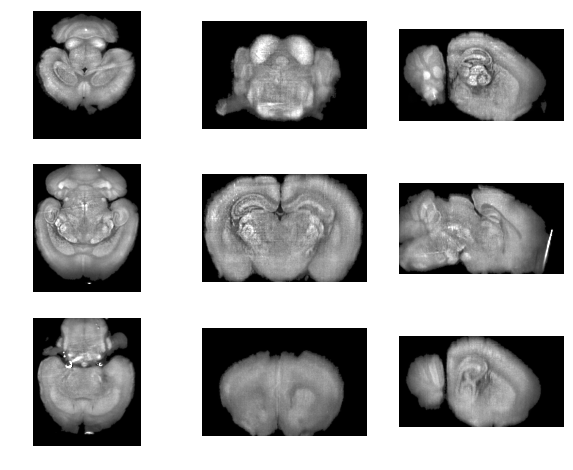

In [12]:
ndreg.imgShow(img_p, vmax=1000)

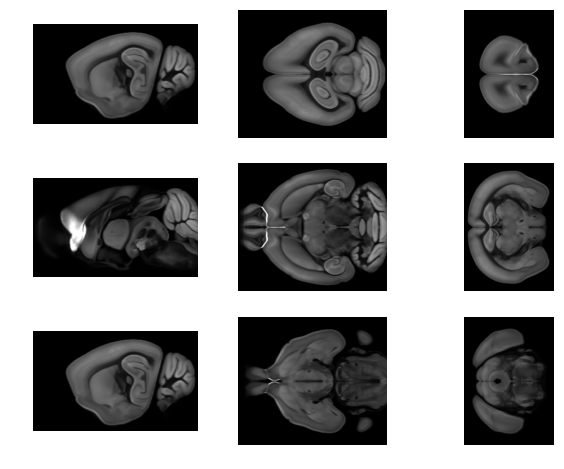

In [13]:
ndreg.imgShow(atlas)

## Registration

In [9]:
registerer = Registerer(atlas, img, "ASR", "LPS")

### Perform affine registration

In [10]:
atlas_affine = registerer.register_affine(0.050, iterations=500.0, resolutions=8.0)

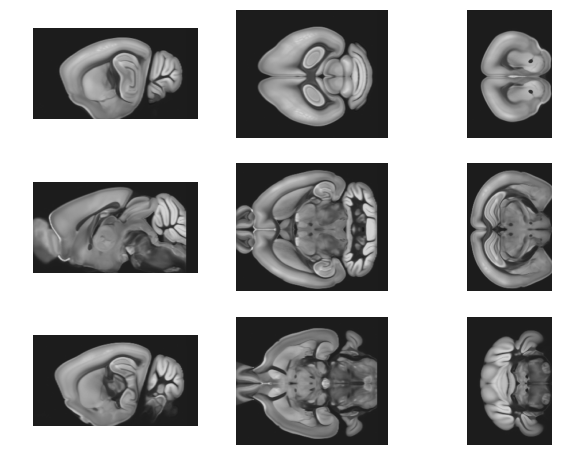

In [11]:
ndreg.imgShow(atlas_affine)

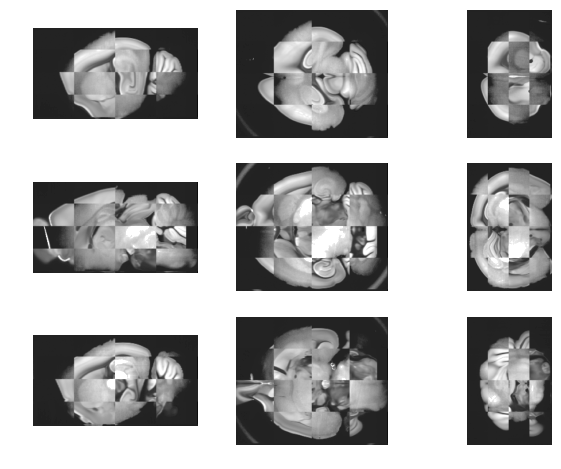

In [12]:
ndreg.imgShow(ndreg.imgChecker(registerer.target_ds, atlas_affine), vmax=1)

In [25]:
mse_affine = registerer.evaluate_affine_registration('../Manual Fiducials/Control9/average_template_10-landmarks.fcsv', 
                                 '../Manual Fiducials/Control9/Control9Auto-landmarks.fcsv', 
                                 0.01/10.0, 0.00516/1.0, "ASL", "RAS")

In [26]:
np.mean(mse_affine)

1.498858339709531

In [27]:
np.median(mse_affine)

1.485936495297308

### Perform LDDMM registration

In [ ]:
atlas_lddmm = registerer.register_lddmm(alpha_list=[0.1], scale_list = 0.10, 
                                        epsilon_list=1e-4, sigma=1e-5, 
                                        use_mi=False, iterations=400, 
                                        verbose=True)


Step 0: alpha=0.1, beta=0.05, scale=0.1


In [ ]:
ndreg.imgShow(atlas_lddmm)

In [ ]:
ndreg.imgShow(ndreg.imgChecker(registerer.target_reoriented, atlas_lddmm), vmax=300)

### Evaluate registration

In [ ]:
mse_lddmm = registerer.evaluate_lddmm_registration('../Manual Fiducials/Control9/average_template_10-landmarks.fcsv', 
                                                   '../Manual Fiducials/Control9/Control9Auto-landmarks.fcsv', 
                                                   0.01/10.0, 0.00516/1.0, "ASL", "RAS")

In [ ]:
np.mean(mse_lddmm)

In [ ]:
np.median(mse_lddmm)

In [ ]:
atlasFids = registerer._parse_fiducial_file('../Manual Fiducials/Control9/average_template_10-landmarks.fcsv', 0.01/10.0)
print(atlasFids[-1])

In [ ]:
rawFids = registerer._parse_fiducial_file('../Manual Fiducials/Control9/Control9Auto-landmarks.fcsv', 0.00516/1.0)
print(rawFids[-1])

In [ ]:
pt = [int(i / 0.005159994528456835) for i in rawFids[-1]]
plt.imshow(sitk.GetArrayViewFromImage(img[:,pt[1],:]), vmax=3000)
plt.plot(pt[0], pt[2], 'ro')
plt.show()

In [ ]:
x = ndreg.imgRead('../phix.img')
y = ndreg.imgRead('../phiy.img')
z = ndreg.imgRead('../phiz.img')

In [ ]:
ndreg.imgShow(z, vmax=10000)

In [ ]:
elastix_x = sitk.ElastixImageFilter()

In [ ]:
img.GetSize()

In [ ]:
out = lmk_apply_field(atlasFids_reoriented, ndreg.affineToField(registerer.affine, registerer.field.GetSize(), registerer.field.GetSpacing()))

In [ ]:
test_out = registerer._compute_error(np.array(out), rawFids)

In [ ]:
np.mean(test_out)

In [ ]:
def lmk_apply_field(inLmk, field):
    dim = 3
    # Create transform
    transform = sitk.DisplacementFieldTransform(dim)
    transform.SetInterpolator(sitk.sitkLinear)
    transform.SetDisplacementField(sitk.Cast(field, sitk.sitkVectorFloat64))

    outLmkList = []
    for lmk in inLmk:
        print(lmk)
        outPoint = transform.TransformPoint(lmk)
        print(outPoint)
        outLmkList.append(outPoint)

    return outLmkList

In [ ]:
lmk_apply_field(atlasFidsR, ndreg.affineToField(registerer.affine, atlas.GetSize(), atlas.GetSpacing()))

In [ ]:
transform = sitk.DisplacementFieldTransform(3)
transform.SetInterpolator(sitk.sitkLinear)
transform.SetDisplacementField(sitk.Cast(ndreg.affineToField(registerer.affine, atlas.GetSize(), atlas.GetSpacing()), sitk.sitkVectorFloat64))

In [ ]:
df = sitk.Cast(transform.GetDisplacementField(), sitk.sitkFloat32)
ndreg.imgShow(sitk.GetArrayViewFromImage(df[80,:,:]))

In [ ]:
import registration_utilities as ru

In [ ]:
transformixImageFilter = sitk.TransformixImageFilter()

In [ ]:
transformixImageFilter.SetTransformParameterMap(registerer.elastix_img_filt.GetParameterMap())

In [ ]:
out_pts = [at.TransformPoint(i) for i in atlasFids]

In [ ]:
x = registerer.elastix_img_filt

In [ ]:
center = x.GetTransformParameterMap()[0]['CenterOfRotationPoint']
affine = [float(i) for i in x.GetTransformParameterMap()[0]['TransformParameters']]

In [ ]:
affine = np.array(affine)

In [ ]:
affine[:9].reshape((3,3))

In [ ]:
center_f = [float(i) for i in center]

In [ ]:
center_f = np.array(center_f)

In [ ]:
at = sitk.AffineTransform(3)

In [ ]:
at.SetCenter(center_f)

In [ ]:
at.SetMatrix(affine[:9])

In [ ]:
at.SetTranslation(affine[9:])

In [ ]:
at.TransformPoint()

In [ ]:
at.GetCenter()

In [ ]:
out_pts

In [ ]:
out_pts_2 = lmk_apply_field(atlasFids, ndreg.affineToField(registerer.affine, (1320, 800, 1140), (0.01, 0.01, 0.01)))

In [ ]:
out_pts1 = registerer._reorient_landmarks(out_pts, "ASR", "LAS", atlas)

In [ ]:
out_pts2 = registerer._reorient_landmarks(out_pts_2, "ASR", "LAS", atlas)

In [ ]:
np.mean(registerer._compute_error(out_pts1, rawFids))

In [ ]:
np.mean(registerer._compute_error(out_pts2, rawFids))

In [ ]:
disp_f = sitk.DisplacementFieldTransform(3)

In [ ]:
x = sitk.GetArrayFromImage(registerer.field)

In [ ]:
field_copy = sitk.GetImageFromArray(x)

In [ ]:
field_copy.CopyInformation(registerer.field)

In [ ]:
disp_f.SetDisplacementField(sitk.Cast(field_copy, sitk.sitkVectorFloat64))

In [ ]:
disp_f.GetParameters()

In [ ]:
print("before: {}".format(out_pts[-1]))
print("after: {}".format(disp_f.TransformPoint(out_pts[-1])))

In [ ]:
rawFids

In [ ]:
out_pts1_lddmm = [disp_f.TransformPoint(i) for i in out_pts]
out_pts1_lddmm_r = registerer._reorient_landmarks(out_pts1_lddmm, "ASR", "LAS", atlas)

In [ ]:
np.mean(registerer._compute_error(out_pts1_lddmm_r, rawFids))

In [ ]:
out_pts2_lddmm = lmk_apply_field(out_pts_2, registerer.field)
out_pts2_lddmm_r = registerer._reorient_landmarks(out_pts2_lddmm, "ASR", "RAS", atlas)

In [ ]:
np.mean(registerer._compute_error(out_pts2_lddmm_r, rawFids))

In [ ]:
disp_f = sitk.DisplacementFieldTransform(3)

In [ ]:
disp_f.SetDisplacementField()

In [ ]:
x = sitk.GetArrayFromImage(registerer.field)

In [ ]:
plt.imshow(x[5,:,:,0])

In [ ]:
x.max()

In [ ]:
x.min()

In [ ]:
field_copy = sitk.GetImageFromArray(x)

In [ ]:
field_copy.CopyInformation(registerer.field)

In [ ]:
disp_f.SetDisplacementField(field_copy)

In [ ]:
disp_f.GetParameters()

In [ ]:
out1 = ndreg.imgApplyField(atlas_affine, registerer.field, size=registerer.target_reoriented.GetSize(), 
                           spacing=registerer.target_reoriented.GetSpacing())